In [1]:
import itertools
import math


import gsd.hoomd
import hoomd
import matplotlib
import numpy

import h5py
import numpy as np


%matplotlib inline
matplotlib.style.use('default')

In [18]:
def init_sim(q1, q2, rot_freedom=False, log_name=None, log_path=None):
    dimer_positions = [[-0.6, 0, 0], [0.6, 0, 0]]


    gpu = hoomd.device.GPU()
    sim = hoomd.Simulation(device=gpu, seed=1)
    sim.create_state_from_gsd(filename='lattice.gsd')


    rigid = hoomd.md.constrain.Rigid()

    rigid.body['dimer'] = {
        "constituent_types": ['A', 'B'],
        "positions": dimer_positions,
        "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
        "charges": [0.0, 0.0],
        "diameters": [1., 1.]
    }

    rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
    R1_filter = hoomd.filter.Tags([0])
    _filter= hoomd.filter.SetDifference(rigid_centers_and_free, R1_filter)

    integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=rot_freedom)
    sim.operations.integrator = integrator


    integrator.rigid = rigid

    kT = 1.5
    nvt = hoomd.md.methods.NVT(kT=kT, tau=1., filter=_filter)
#     integrator.methods.append(nvt)
    cap = hoomd.md.methods.DisplacementCapped(filter=_filter, maximum_displacement=1e-1)
    integrator.methods.append(cap)
    
    
    cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])

    lj = hoomd.md.pair.LJ(nlist=cell)
    lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
    lj.r_cut[('A', 'A')] = 2.8

    lj.params[('B', 'B')] = dict(epsilon=1, sigma=1)
    lj.r_cut[('B', 'B')] = 2.8

    lj.params[('A', 'B')] = dict(epsilon=1, sigma=1)
    lj.r_cut[('A', 'B')] = 2.8

    lj.params[('dimer', ['dimer', 'A', 'B'])] = dict(epsilon=0, sigma=0)
    lj.r_cut[('dimer', ['dimer', 'A', 'B'])] = 0

    integrator.forces.append(lj)

    thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())

    sim.operations.computes.append(thermodynamic_quantities)

    sim.state.thermalize_particle_momenta(filter=_filter, kT=kT)
    
#     with sim._state.cpu_local_snapshot as data:
#         rtag = data.particles.rtag
#         idx_0 = rtag[0]
#         idx_1 = rtag[1]
#         data.particles.orientation[idx_0] = q1
#         data.particles.position[idx_0] = [-2, 0, 0.]
#         data.particles.orientation[idx_1] = q2
#     sim.run(0)


#     nvt.thermalize_thermostat_dof()
    if log_name:

        # Logging 
        log_quantities = [
                    "kinetic_temperature",
                    "potential_energy",
                    "kinetic_energy",
                    "volume",
                    "pressure",
                    "pressure_tensor",
                ]
        logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
        logger.add(sim, quantities=["timestep", "tps"])
        thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
        sim.operations.computes.append(thermo_props)
        logger.add(thermo_props, quantities=log_quantities)

        for f in integrator.forces:

            logger.add(f, quantities=["energy", "forces", "energies"])

        gsd_writer = hoomd.write.GSD(
            filename=os.path.join(log_path, f"{log_name}_trajectory.gsd"),
            trigger=hoomd.trigger.Periodic(int(1)),
            mode="wb",
            logger=logger,
            dynamic=["momentum"]
            )

        sim.operations.writers.append(gsd_writer)

    
    
    return sim

In [63]:
sim_obj = init_sim(q1=[1, 0, 0, 0], q2=[1, 0, 0,0])

In [64]:
with sim_obj._state.cpu_local_snapshot as data:
    rtag = data.particles.rtag
    idx_0 = rtag[0]
    idx_1 = rtag[1]
    data.particles.position[idx_0] = [-3, 0, 0.]
    data.particles.position[idx_1] = [-1, 0, 0]

In [65]:
sim_obj.run(0)
hoomd.write.GSD.write(state=sim_obj.state, mode='wb', filename='../lattice_init.gsd')

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.


In [57]:
with sim_obj._state.cpu_local_snapshot as data:
    print(data.particles.net_force)

HOOMDArray([[ 2.96801984e-02  6.28688858e-05 -6.13812686e-05]
 [-2.96801984e-02 -6.28688858e-05  6.13812686e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]])


In [58]:
sim_obj.operations.computes[0].potential_energy

-0.012903834102723192

## Fix Quaternions

In [3]:
import numpy as np
import rowan

In [4]:
def rot_z(A, angle):
    return A @ np.array(
        [
            [np.cos(angle), -np.sin(angle), 0.0],
            [np.sin(angle), np.cos(angle), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )

def rot_y(A, angle):
    return A @ np.array(
        [
            [np.cos(angle), 0.0, np.sin(angle)],
            [0.0, 1.0, 0.0],
            [-np.sin(angle), 0.0, np.cos(angle)],
        ]
    )


In [5]:

A0 = np.eye(3)
A1 = rot_z(A0, np.pi / 2)
A2 = rot_y(A0, np.pi/2)
# A3 = rot_y(A1, np.pi/2)
A3 = rot_z(A0, np.pi/4)

In [6]:
# quaternions = [rowan.from_matrix(A1), rowan.from_matrix(A0), rowan.from_matrix(A1), rowan.from_matrix(A2), rowan.from_matrix(A3), rowan.normalize([0.5, 0.5, 0.5, 0.5])]

In [16]:
fixed_quaternions = [(rowan.from_matrix(A1),rowan.from_matrix(A2)),
                    (rowan.from_matrix(A1),rowan.from_matrix(A1)),
                    (rowan.from_matrix(A1),rowan.from_matrix(A0)),
                    (rowan.from_matrix(A1),rowan.from_matrix(A3)),
                     (rowan.from_matrix(A0),rowan.from_matrix(A3)),
                    (rowan.from_matrix(A0),rowan.from_matrix(A0)),
                    ]

In [17]:
init_position = -1
final_position = 2.5
grid_step = (final_position - init_position)/200


In [18]:
# dimer_positions = [[-0.7, 0, 0], [0.7, 0, 0]]

In [19]:
import os
import warnings
warnings.filterwarnings("ignore")

In [20]:
# energy_position_dict = {}

In [21]:
energy_position_dict = {}
for i, (q1, q2) in enumerate(fixed_quaternions):
    energies = []
    positions = []
    run_name = f"orientation_{i}"
    run_path = os.path.join("dimer_fix_orientations", run_name)
    if not os.path.exists(run_path):
        os.mkdir(run_path)
    print(f"*********** {run_name}*********")
    sim_obj = init_sim(q1, q2, rot_freedom=False, log_name=run_name, log_path=run_path)
    for x in np.arange(init_position, final_position, grid_step):
        with sim_obj.state.cpu_local_snapshot as data:
            rtag = data.particles.rtag
            idx_0 = rtag[0]
            idx_1 = rtag[1]
            data.particles.orientation[idx_0] = q1
            data.particles.position[idx_0] = [init_position - 0.2, 0, 0.]
            data.particles.orientation[idx_1] = q2
            data.particles.position[idx_1] = (x,0, 0)

        sim_obj.run(0, write_at_start=True)
        energies.append(sim_obj.operations.integrator.forces[0].energy)
        with sim_obj.state.cpu_local_snapshot as data:
            rtag = data.particles.rtag
            idx_0 = rtag[0]
            idx_1 = rtag[1]

            positions.append([np.array(data.particles.position[idx_0]), 
                              np.array(data.particles.position[idx_1])])

        try:

            sim_obj.run(1)
        except:
            pass
    energy_position_dict[run_name] = (positions, energies)


*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*********** orientation_0*********


*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*********** orientation_1*********


*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*********** orientation_2*********


*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*********** orientation_3*********


*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_rotational_dof isfalse.
*Warning*: Forces provide torques, but integrate_ro

In [23]:
# for i, q1 in enumerate(quaternions):
#     for j, q2 in enumerate(quaternions):
#         energies = []
#         positions = []
#         run_name = f"q{i}_q{j}"
#         run_path = os.path.join("dimer_fix_orientations", run_name)
#         if not os.path.exists(run_path):
#             os.mkdir(run_path)
#         print(f"*********** {run_name}*********")
#         sim_obj = init_sim(q1, q2, rot_freedom=False, log_name=run_name, log_path=run_path)
#         for x in np.arange(init_position, final_position, grid_step):
#             with sim_obj.state.cpu_local_snapshot as data:
#                 rtag = data.particles.rtag
#                 idx_0 = rtag[0]
#                 idx_1 = rtag[1]
#                 data.particles.orientation[idx_0] = q1
#                 data.particles.position[idx_0] = [init_position - 0.2, 0, 0.]
#                 data.particles.orientation[idx_1] = q2
#                 data.particles.position[idx_1] = (x,0, 0)
                
#             sim_obj.run(0, write_at_start=True)
#             energies.append(sim_obj.operations.integrator.forces[0].energy)
#             with sim_obj.state.cpu_local_snapshot as data:
#                 rtag = data.particles.rtag
#                 idx_0 = rtag[0]
#                 idx_1 = rtag[1]
                
#                 positions.append([np.array(data.particles.position[idx_0]), 
#                                   np.array(data.particles.position[idx_1])])
# #                 q_orientations.append(data.particles.orientation[com_idx])
# #                 forces.append(data.particles.net_force[com_idx])
# #                 q_torques.append(data.particles.net_torque[com_idx])
#             try:

#                 sim_obj.run(1)
#             except:
#                 pass
#         energy_position_dict[run_name] = (positions, energies)
# #         break
# #     break
       
    


In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
import matplotlib.cm as cm

colors = cm.nipy_spectral(np.linspace(0, 1, len(fixed_quaternions)))

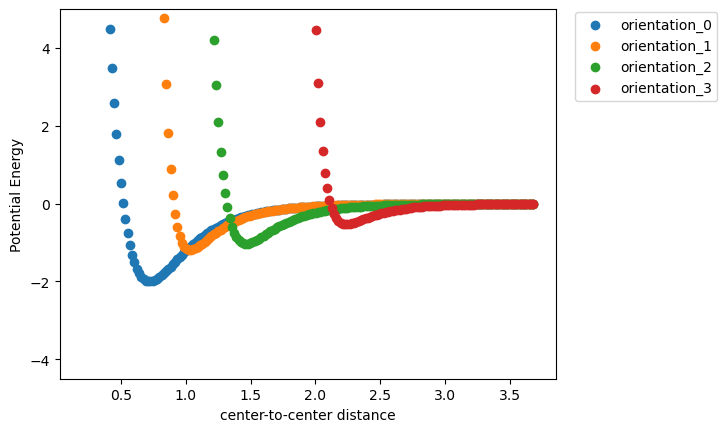

In [24]:
for k, col in zip(energy_position_dict.keys(), colors):
    r = np.linalg.norm(np.asarray(energy_position_dict[k][0])[:, 0] - np.asarray(energy_position_dict[k][0])[:, 1], axis=1)
    e = np.asarray(energy_position_dict[k][1]) / 2.
    plt.scatter(r, e, label = k)
plt.ylim(-4.5, 5)
plt.legend(bbox_to_anchor=(1.34, 1.01))
plt.ylabel("Potential Energy")
plt.xlabel("center-to-center distance")
plt.savefig("Dimer_E_R.png")

In [214]:
# for k, v in energy_position_dict.items():
#     if k in desired_orientations:
#         r = np.linalg.norm(np.asarray(energy_position_dict[k][0])[:, 0] - np.asarray(energy_position_dict[k][0])[:, 1], axis=1)
#         e = np.asarray(energy_position_dict[k][1])
#         plt.scatter(r, e, label = k, c)
# plt.ylim(-5, 6)
# plt.legend(bbox_to_anchor=(1.25, 1.01))

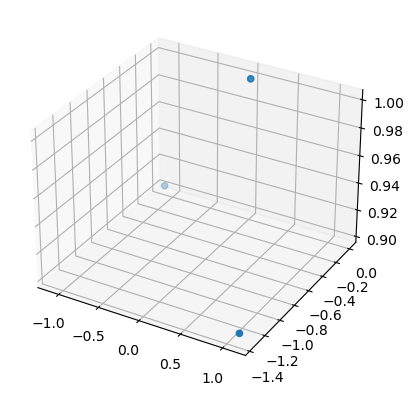

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

theta, phi = np.linspace(0, np.pi, 2), np.linspace(0, np.pi, 2)
THETA, PHI = np.meshgrid(theta, phi)
R = np.cos(PHI**2)
X = R * np.sin(PHI) * np.cos(THETA)
Y = R * np.sin(PHI) * np.sin(THETA)
Z = R * np.cos(PHI)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(
    X, Y, Z)

plt.show()

In [4]:
Z

array([[1.        , 1.        ],
       [0.90268536, 0.90268536]])